# Exercise 1 - Mathematical Foundations of Computer Graphics and Vision
Andreas Voigt - FS2021

In [1]:
%matplotlib inline

import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
import time
from scipy.optimize import linprog

# np.random.seed(int(time.time()))
np.random.seed(42) # Make results reproducable for hand-in

## Part 1: RANSAC for Circle Fitting
### 1.1: Data generation

In [2]:
# Define constant parameters for this exercise
ground_truth_center = np.array([0,0])
ground_truth_radius = 5

n_points = 100
outlier_ratio = 0.2
noise_amplitude = 0.1
domain_size = 10

(-10.0, 10.0, -10.0, 10.0)

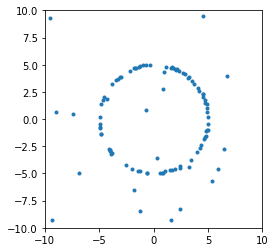

In [3]:
def generate_circle_data(center, radius, n_points, outlier_ratio, noise_amplitude, domain_size):
    n_inliers = int(n_points * (1-outlier_ratio))
    n_outliers = n_points - n_inliers

    # Generate inliers on circle
    angles = np.random.rand(n_inliers) * 2 * np.pi
    inliers = center + np.stack([np.cos(angles) * radius, np.sin(angles) * radius]).T # Generate points without noise

    # Rejection sampling: only accept noise with norm smaller than noise_amplitude. 
    for i in range(inliers.shape[0]):
        while True:
            noise = (np.random.rand(2) - 0.5) * 2 * noise_amplitude
            if np.linalg.norm(noise) <= noise_amplitude:
                inliers[i,:] += noise
                break

    outliers = (np.random.rand(n_outliers, 2) - 0.5) * 2 * domain_size
    data = np.vstack([inliers, outliers])
    return data

data = generate_circle_data(ground_truth_center, ground_truth_radius, n_points, outlier_ratio, noise_amplitude, domain_size)
plt.scatter(data[:,0], data[:,1], marker='.');
plt.axis("scaled");
plt.axis([-domain_size, domain_size, -domain_size, domain_size])

## Fitting and Inlier-Classification
We will now define a class representing a circle that will be used in the RANSAC step below. 

### Least-Squares Fitting
A circle is uniquely defined by 3 parameters: $x_{center}, y_{center}, r$. The circle equation is then given by:

$$
    \begin{align}
        (x-x_{center})^2 + (y-y_{center})^2 &= r^2 \\
        2x\underbrace{x_{center}}_{a} + 2y\underbrace{y_{center}}_{b} + \underbrace{r^2-x_{center}^2-y_{center}^2}_{c} &= x^2 + y^2 \\
        \left( \begin{matrix} 2x & 2y & 1 \end{matrix} \right) \left( \begin{matrix} a \\ b \\ c \end{matrix} \right) &= x^2 + y^2
    \end{align}
$$

For $n$ datapoints, the last equation can be stacked n times to get a matrix-vector equation that can be solved in the least-squares sense.

$$
    \left( \begin{matrix} 
        2x_1 & 2y_1 & 1  \\
        \vdots & \vdots & \vdots  \\
        2x_n & 2y_n & 1  \\
    \end{matrix} \right) 
    \left( \begin{matrix} a \\ b \\ c \end{matrix} \right) = 
    \left( \begin{matrix} 
        x_1^2 + y_1^2  \\
        \vdots \\
        x_n^2 + y_n^2 \\
    \end{matrix} \right)
$$

The center is then given by: $ x_{center} = a, y_{center} = b $ and the radius by $ r = \sqrt{c+a^2+b^2} $.

### Inlier-Classification
Next we need to define a function to classify inliers given a fitted circle. We therefore calculate the distance to the circle center for each given datapoint. All points that have a distance in the interval $[R-\tau, R+\tau]$ are classified as inliers, all others as outliers.

### Code

In [4]:
class Circle:
    sample_size = 3

    def __init__(self, center, radius):
        self.cx = center[0]
        self.cy = center[1]
        self.r = radius
    
    @classmethod    
    def fit(cls, data):
        """
        Fits a circle in the provided data and returns a new instance of Circle
        """
        A = np.hstack([2*data, np.ones([data.shape[0], 1])])
        b = np.sum(data**2, axis=1)
        x = np.linalg.lstsq(A, b)[0]      
        cx = x[0]
        cy = x[1]
        r = np.sqrt(x[2] + cx**2 + cy**2)
        return cls((cx, cy), r)

    def get_inlier_mask(self, data, threshold):
        center_distances = np.linalg.norm(data-np.array([self.cx, self.cy]), axis=1)
        errors = np.abs(center_distances - self.r)
        return errors <= threshold

Now let us check if the class works:

<ipython-input-4-7335d45835fe>:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0]
Check fitting:
	Fitted Circle: x:+0.01073, y:+0.00385, r:+4.99637
	Ground truth circle: x:+0.00000, y:+0.00000, r:+5.00000
Check inlier classification:
	Estimated inliers: 80, Estimated outliers: 20, Estimated outlier ratio: 0.2
	Ground truth inliers: 80, Ground truth outliers: 20, Ground truth outlier ratio: 0.2


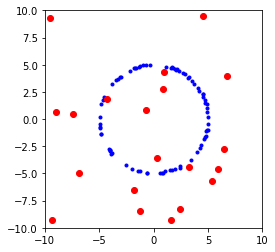

In [5]:
fitted_circle = Circle.fit(data[:int(n_points*(1-outlier_ratio)),:]) # A bit hacky but we know that all inliers are in the first portion of data... ;)
ground_truth_circle = Circle(ground_truth_center, ground_truth_radius)
inlier_mask = ground_truth_circle.get_inlier_mask(data, noise_amplitude)

print("Check fitting:")
print(f"\tFitted Circle: x:{fitted_circle.cx:+.5f}, y:{fitted_circle.cy:+.5f}, r:{fitted_circle.r:+.5f}")
print(f"\tGround truth circle: x:{ground_truth_circle.cx:+.5f}, y:{ground_truth_circle.cy:+.5f}, r:{ground_truth_circle.r:+.5f}")

print("Check inlier classification:")
print(f"\tEstimated inliers: {np.count_nonzero(inlier_mask)}, Estimated outliers: {np.count_nonzero(~inlier_mask)}, Estimated outlier ratio: {np.count_nonzero(~inlier_mask)/len(inlier_mask)}")
print(f"\tGround truth inliers: {int(n_points * (1-outlier_ratio))}, Ground truth outliers: {n_points - int(n_points * (1-outlier_ratio))}, Ground truth outlier ratio: {outlier_ratio}")

plt.scatter(data[inlier_mask,0], data[inlier_mask,1], c='b', marker='.')
plt.scatter(data[~inlier_mask,0], data[~inlier_mask,1], c='r', marker='o')
plt.axis('scaled')
plt.axis([-domain_size, domain_size, -domain_size, domain_size])
plt.show();
    

## 1.2 RANSAC
In the next section we will implement the RANSAC algorithm for a generic model. It will then be applied to the circle model defined above.

In [6]:
def ransac(data, model, outlier_ratio, success_rate, refit_model=False):
    # calculate the theoretical number of iterations
    n_iter = math.ceil(math.log(1-success_rate)/math.log(1-(1-outlier_ratio)**model.sample_size))

    best_inlier_mask = np.zeros(data.shape[0], dtype=bool)
    best_model = None
    for i in range(n_iter):
        indices = np.random.choice(data.shape[0], model.sample_size, replace=False)
        current_model = model.fit(data[indices,:])
        inlier_mask = current_model.get_inlier_mask(data, noise_amplitude)
        if np.count_nonzero(inlier_mask) > np.count_nonzero(best_inlier_mask):
            best_inlier_mask = inlier_mask
            best_model = current_model
    if refit_model:
        best_model = Circle.fit(data[best_inlier_mask,:])
    return best_model, best_inlier_mask    

In [7]:
ransac_circle, ransac_inlier_mask = ransac(data, Circle, outlier_ratio, 0.99)
print(f"RANSAC Circle: x:{ransac_circle.cx:+.5f}, y:{ransac_circle.cy:+.5f}, r:{ransac_circle.r:+.5f}")
print(f"Ground truth circle: x:{ground_truth_circle.cx:+.5f}, y:{ground_truth_circle.cy:+.5f}, r:{ground_truth_circle.r:+.5f}")

RANSAC Circle: x:+0.03660, y:+0.05191, r:+5.00665
Ground truth circle: x:+0.00000, y:+0.00000, r:+5.00000
<ipython-input-4-7335d45835fe>:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0]


#### Testing RANSAC with Different Outlier Ratios

<ipython-input-4-7335d45835fe>:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0]
<ipython-input-4-7335d45835fe>:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0]
<ipython-input-4-7335d45835fe>:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass

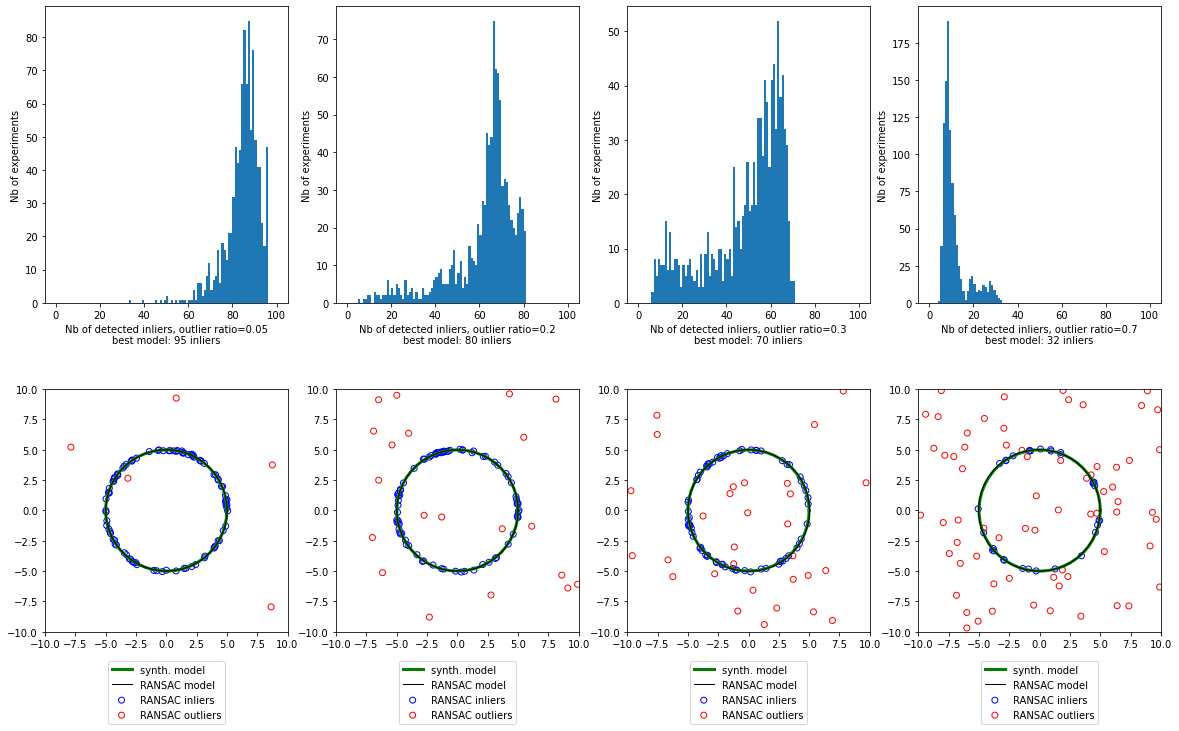

In [8]:
outlier_ratios = (0.05, 0.2, 0.3, 0.7)
n_ransac_calls = 1000

def get_circle_points(circle):
    angles = np.linspace(0, 2*np.pi)
    x = circle.cx + circle.r * np.cos(angles)
    y = circle.cy + circle.r * np.sin(angles)
    return x, y

plt.figure(figsize=(20, 12))
for r, ratio in enumerate(outlier_ratios):
    data = generate_circle_data(ground_truth_center, ground_truth_radius, n_points, ratio, noise_amplitude, domain_size)
    inlier_buffer = np.zeros(n_ransac_calls)

    best_ransac_model = None
    best_inlier_mask = np.zeros(data.shape[0], dtype=bool)
    max_inliers = 0
    for i in range(n_ransac_calls):
        ransac_circle, ransac_inlier_mask = ransac(data, Circle, outlier_ratio, 0.99)
        n_inliers = np.count_nonzero(ransac_inlier_mask)
        inlier_buffer[i] = n_inliers
        if n_inliers > max_inliers:
            best_ransac_model = ransac_circle
            best_inlier_mask = ransac_inlier_mask
            max_inliers = n_inliers
    
    plt.subplot(2, len(outlier_ratios), r+1)
    plt.hist(inlier_buffer, 100, (0, 100))
    plt.xlabel(f"Nb of detected inliers, outlier ratio={ratio}\nbest model: {max_inliers} inliers")
    plt.ylabel("Nb of experiments")
    
    plt.subplot(2, len(outlier_ratios), r+1+len(outlier_ratios))
    plt.plot(*get_circle_points(ground_truth_circle), color='g', lw=3)
    plt.plot(*get_circle_points(best_ransac_model), color='k', lw=1)
    plt.scatter(data[best_inlier_mask,0], data[best_inlier_mask,1], facecolors='none', edgecolors='b')
    plt.scatter(data[~best_inlier_mask,0], data[~best_inlier_mask,1], facecolors='none', edgecolors='r')
    plt.axis('scaled')
    plt.axis([-domain_size, domain_size, -domain_size, domain_size])
    plt.legend(("synth. model", "RANSAC model", "RANSAC inliers", "RANSAC outliers"), 
               loc="lower center", bbox_to_anchor=(0.5, -0.4))    

## 1.3 Exhaustive Search
Try all combinations of 3 data points and return the best one.

In [9]:
def exhaustive_search(data):
    combs = list(itertools.combinations(data, 3))

    n_inliers = np.zeros(len(combs))
    for i, sample in enumerate(combs):
        circle = Circle.fit(np.array(sample))
        inlier_mask = circle.get_inlier_mask(data, noise_amplitude)
        n_inliers[i] = np.count_nonzero(inlier_mask)
    return combs, n_inliers

In [10]:
data = generate_circle_data(ground_truth_center, ground_truth_radius, n_points, outlier_ratio, noise_amplitude, domain_size)
combinations, n_inliers = exhaustive_search(data)
best_exhaustive_circle = Circle.fit(np.array(combinations[np.argmax(n_inliers)]))

<ipython-input-4-7335d45835fe>:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0]


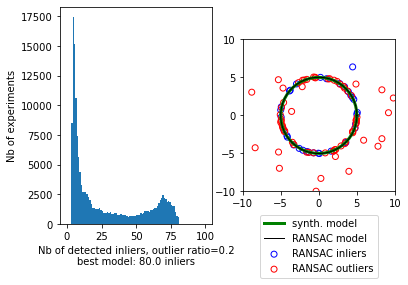

In [11]:
plt.subplot(121)
plt.hist(n_inliers, 100, (0, 100))
plt.xlabel(f"Nb of detected inliers, outlier ratio={outlier_ratio}\nbest model: {np.max(n_inliers)} inliers")
plt.ylabel("Nb of experiments")
plt.subplot(122)    
plt.plot(*get_circle_points(ground_truth_circle), color='g', lw=3)
plt.plot(*get_circle_points(best_exhaustive_circle), color='k', lw=1)
inlier_mask = best_exhaustive_circle.get_inlier_mask(data, noise_amplitude)
plt.scatter(data[best_inlier_mask,0], data[best_inlier_mask,1], facecolors='none', edgecolors='b')
plt.scatter(data[~best_inlier_mask,0], data[~best_inlier_mask,1], facecolors='none', edgecolors='r')
plt.axis('scaled')
plt.axis([-domain_size, domain_size, -domain_size, domain_size])
plt.legend(("synth. model", "RANSAC model", "RANSAC inliers", "RANSAC outliers"), 
            loc="lower center", bbox_to_anchor=(0.5, -0.6))    ;

## Discussion
* **How many combinations (exhaustive search) exist for $N=100$ point?** -> there are $\binom{N}{3} = N(N-1)(N-2)/6 = 161700$ combinations.


In [12]:
print(f"N*(N-1)*(N-2)/6 = {n_points*(n_points-1)*(n_points-2)/6}")
print(f"Length of combination list: {len(combinations)}")

N*(N-1)*(N-2)/6 = 161700.0
Length of combination list: 161700


* **What about the number of RANSAC iterations with $r=5$%, $20$%, $30$%, $70$%?** -> the number of RANSAC iterations is given by 
$$
    k = \frac{\log{1-p_{success}}}{\log{1-(1-r_{outlier})^{sample size}}}
$$

In [13]:
for r in outlier_ratios:
    print(f"Number of RANSAC iterations for r={r:.2f}: {math.ceil(math.log(1-0.99)/math.log(1-(1-r)**3))}")

Number of RANSAC iterations for r=0.05: 3
Number of RANSAC iterations for r=0.20: 7
Number of RANSAC iterations for r=0.30: 11
Number of RANSAC iterations for r=0.70: 169


* **What about when $N=100000$?** -> the number of RANSAC iterations stays the same because there is no dependency on the number of data points. The number of exhaustive combinations gets even bigger (see below). RANSAC is therefore much more efficient! 

In [14]:
print(f"N*(N-1)*(N-2)/6 = {100000*(100000-1)*(100000-2)/6}")

N*(N-1)*(N-2)/6 = 166661666700000.0


* **Does exhaustive search on all the combinations of data points guarantee the optimal solution (in terms of number of inliers)? Why?** -> No, even the exhaustive search doesn't guarantee the optimal solution because all hypotheses are directly supported by the chosen 3 samples. The samples are noisy, thus there is no guarantee that the 3 samples reconstruct original (optimal) circle. 
* **Discuss and compare the results obtained by RANSAC and exhaustive search in terms of number of inliers, speed, number of synthesized inliers, etc. **
  - RANSAC and the exhaustive search both suffer from the same problem: both try hypotheses that are directly supported by the 3 noisy samples. There is no guarantee to obtain the optimal solution (in terms of inliers). 
  - RANSAC has a probabilistic behaviour and gives different results for each run. Exhaustive search is non-probabilistic and always returns the same results which is often convenient
  - On the other hand, exhaustive serach is much more expensive than RANSAC (e.g. 161700 vs 169 iterations) and grows like $O(N^s)$ while RANSAC stays constant in then number of data-points $N$.
  - The RANSAC-result is only correct with a given probability (e.g. 99%). This means on the other hand that there are cases when RANSAC outputs a very wrong result (i.e. one that has far less inliers than expected). This can be seen in the plots as there are some RANSAC calls that returned models with very few inliers (small values on the left side in the histogram).

## Part 2: IRLS and norms for line fitting
### 2.1: Data generation

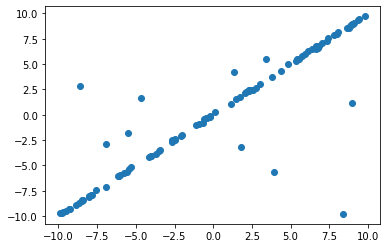

In [15]:
def generate_line_data(n_points, a, b, outlier_ratio, noise_amplitude, x_domain):
    n_inliers = int(n_points * (1-outlier_ratio))
    n_outliers = n_points - n_inliers

    x = (np.random.rand(n_inliers)-0.5) * 2 * x_domain
    y = a * x + b

    inliers = np.vstack([x, y]).T
    inliers += (np.random.rand(*inliers.shape)-0.5) * 2 * noise_amplitude

    outliers_x = (np.random.rand(n_outliers)-0.5) * 2 * x_domain
    outliers_y = (np.random.rand(n_outliers)-0.5) * 2 * (a*x_domain+b)
    outliers = np.vstack([outliers_x, outliers_y]).T

    data = np.vstack([inliers, outliers])
    return data

data = generate_line_data(100, 1, 0, 0.1, 0.1, 10)
plt.scatter(data[:,0], data[:,1]);

### 2.2 $L_1$ Norm with Linear Programming
As seen in the lecture, we can write the minimization of $||Ax-b||_1$ as:
$$
\min_{x,t_1,...,t_n}{\sum_{i=1}^{n}{t_i}} \\
s.th -t_i \leq A_ix - b_i \leq t_i, \forall i=1,...,n
$$
Where $A_i = \left( \begin{matrix} x_i & 1 \end{matrix} \right),
       x = \left( \begin{matrix} a  \\  b \end{matrix} \right),
       b_i=y_i$. 
       
We reformulate it to match the LP-convention needed by Scipy:
$$
    \min_{\tilde{x}}{c^T\tilde{x}} \\
    s.th. A_{ub}\tilde{x} \leq b_{ub}
$$
where
$$
    \tilde{x} = \left( \begin{matrix} t_1  & \cdots & t_n & a & b \end{matrix} \right)^T,
    c = \left( \begin{matrix} 1  & \cdots & 1 & 0 & 0 \end{matrix} \right)^T
$$
The inequality $-t_i \leq A_ix - b_i \leq t_i$ can be written as
$$
    A_ix-t_i \leq b_i \wedge -A_ix-t_i \leq -b_i
$$
The inequalities can be stacked for all $i$ which gives:
$$
    A_{ub} = 
    \left( \begin{matrix} 
        -1 & \cdots & 0  & x_1 & 1\\
        \vdots & \ddots & \vdots & \vdots & \vdots\\
        0 & \cdots & -1 & x_n & 1 \\
        -1 & \cdots & 0  & -x_1 & -1\\
        \vdots & \ddots & \vdots & \vdots & \vdots\\
        0 & \cdots & -1  & -x_n & -1 \\
    \end{matrix} \right) , 
    b_{ub} = \left( \begin{matrix} y_1 \\ \vdots \\ y_n \\ -y_1 \\ \vdots \\ -y_n \end{matrix} \right)
$$

In [16]:
def fit_L1_LP(data):
    n = data.shape[0]
    c = np.append(np.ones(n), np.array([0,0]))

    A_ub = np.zeros((2*n, n+2))
    A_ub[:n,:n] = -np.eye(n)
    A_ub[n:,:n] = -np.eye(n)
    A_ub[:n,-2] = data[:,0]
    A_ub[n:,-2] = -data[:,0]
    A_ub[:n,-1] = 1
    A_ub[n:,-1] = -1

    b_ub = np.append(data[:,1], -data[:,1])

    res = linprog(c, A_ub=A_ub, b_ub=b_ub)
    return res.x[-2:]

print(fit_L1_LP(data))

[0.99614459 0.01298226]


### 2.2 $L_\infty$ Norm with Linear Programming
As seen in the lecture, we can write the minimization of $||Ax-b||_\infty = \max_{i}{|A_ix-b_i|} $ as:
$$
\min_{x,t}{t} \\
s.th -t \leq A_ix - b_i \leq t, \forall i=1,...,n
$$
Where $A_i = \left( \begin{matrix} x_i & 1 \end{matrix} \right),
       x = \left( \begin{matrix} a  \\  b \end{matrix} \right),
       b_i=y_i$. 
       
We again reformulate it to match the LP-convention needed by Scipy:
$$
    \min_{\tilde{x}}{c^T\tilde{x}} \\
    s.th. A_{ub}\tilde{x} \leq b_{ub}
$$
where
$$
    \tilde{x} = \left( \begin{matrix} t & a & b \end{matrix} \right)^T,
    c = \left( \begin{matrix} 1 & 0 & 0 \end{matrix} \right)^T
$$
The inequality $-t \leq A_i - b_i \leq t$ can be written as
$$
    A_ix-t \leq b_i \wedge -A_ix-t \leq -b_i
$$
The inequalities can be stacked for all $i$ which gives:
$$
    A_{ub} = 
    \left( \begin{matrix} 
        -1 & x_1 & 1\\
        \vdots & \vdots & \vdots\\
        -1 & x_n & 1 \\
        -1 & -x_1 & -1\\
        \vdots & \vdots & \vdots\\
        -1  & -x_n & -1 \\
    \end{matrix} \right) , 
    b_{ub} = \left( \begin{matrix} y_1 \\ \vdots \\ y_n \\ -y_1 \\ \vdots \\ -y_n \end{matrix} \right)
$$

In [17]:
def fit_L_infty_LP(data):
    n = data.shape[0]
    c = np.array([1, 0, 0])

    A_ub = np.zeros((2*n, 3))
    A_ub[:,0] = -1
    A_ub[:n,1] = data[:,0]
    A_ub[n:,1] = -data[:,0]
    A_ub[:n,2] = 1
    A_ub[n:,2] = -1

    b_ub = np.append(data[:,1], -data[:,1])

    res = linprog(c, A_ub=A_ub, b_ub=b_ub)
    return res.x[-2:]
print(fit_L_infty_LP(data))

[2.65446224e-12 4.71582671e-11]


### 2.3 $L_1$ with Iterative Reweighted Least Squares (IRLS)
We apply the algorithm given in the lecture notes to the minimization of $||Ax-b||_1 = \sum_i{A_ix-b_i}$:
$$
    \DeclareMathOperator*{\argmin}{argmin}
    x_{t+1} = \argmin_{x}\sum_i{w_i(x_t)(A_ix-b_i)^2} = \argmin_{x} (Ax-b)^T W(x_t) (Ax-b) 
$$
where $w_i(x_t) = 1/|A_ix_t-b|$ and $W(x_t) = diag(w_1(x_t),\cdots,w_n(x_t)) $.
The minimization is a weightes least-squares problem that can be solved in closed form using the normal equations:
$$
    x_{t+1} = (A^TWA)^{-1}A^TWb
$$ 
In order to avoid divisions by very small values in the calculation of the weights, we set $w_i(x_t) = \frac{1}{min \{ |A_ix_t-b|, \delta \} }$ for a small $\delta$, e.g. $1e-5$. 

The iteration is done until convergence ($x_{t+1} \approx x_t$) or a maximum number of iterations has been reached.

In [18]:
def fit_L1_IRLS(data):
    n = data.shape[0]
    x = np.array([0,0])

    max_iterations = 1000
    delta = 1.0e-5
    x_tol = 1.0e-5
    for i in range(max_iterations):
        A = np.stack([data[:,0], np.ones(n)]).T
        b = data[:,1]
        W = np.diag(1/np.maximum(np.abs(A@x - b), delta)) # make sure that one doesn't get 1/0

        # solved via normal-equations, could be done directly by np.linalg.lstsq but I'm not sure if this is allowed
        x_new = np.linalg.inv(A.T @ W @ A) @ A.T @ W @ b 
        if np.max(np.abs(x_new-x)) < x_tol:
            x = x_new
            break
        x = x_new
    return x
print(fit_L1_IRLS(data))

[0.9961472  0.01296562]


In [19]:
# For comparison
def fit_L2(data):
    n = data.shape[0]
    A = np.stack([data[:,0], np.ones(n)]).T
    b = data[:,1]
    return np.linalg.lstsq(A, b, rcond=None)[0]

In [20]:
def plot_results(outlier_ratio):
    a = 1; b = 0
    noise_amplitude = 0.1
    N = 100
    x_domain = 10

    data = generate_line_data(N, a, b, outlier_ratio, noise_amplitude, x_domain)
    fitted_lines = {"L1 LP": fit_L1_LP(data),
                    "L1 IRLS": fit_L1_IRLS(data),  
                    "L_inf LP": fit_L_infty_LP(data),
                    "L2": fit_L2(data)}

    fig = plt.figure(figsize=(20, 5))
    fig.suptitle(f"Function: {a:.2f}x{b:+.2f}, Outlier ratio: {outlier_ratio:.2f}")
    for l, label in enumerate(fitted_lines):
        line = fitted_lines[label]
        plt.subplot(1, len(fitted_lines), l+1)
        plt.scatter(data[:,0], data[:,1])
        plt.plot([-x_domain, x_domain], [-line[0]*x_domain+line[1], line[0]*x_domain+line[1]], 'b')
        plt.plot([-x_domain, x_domain], [-a*x_domain+b, a*x_domain+b], 'g:')
        plt.title(label + f": {line[0]:.2f}x{line[1]:+.2f}")
        plt.axis([-x_domain, x_domain, -a*x_domain+b, a*x_domain+b])



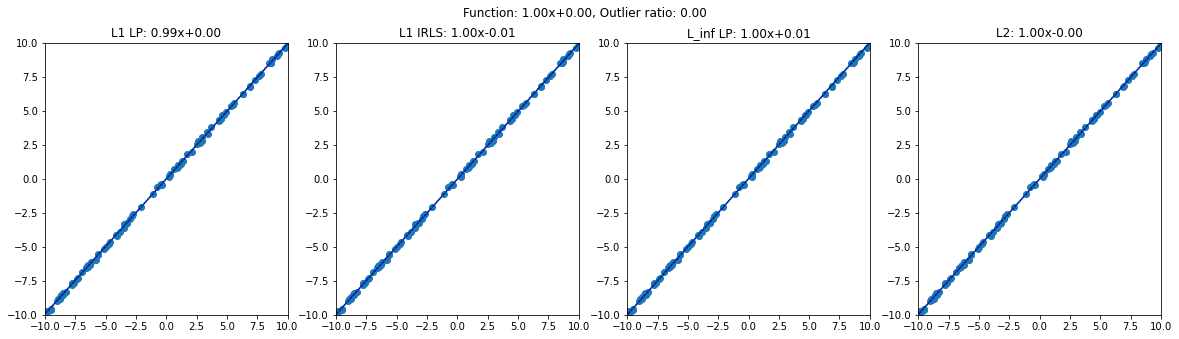

In [21]:
plot_results(0)

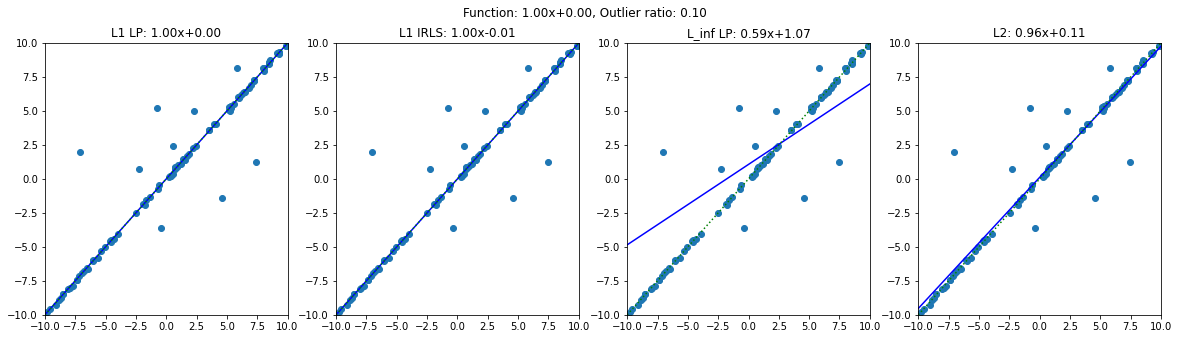

In [22]:
plot_results(0.1)

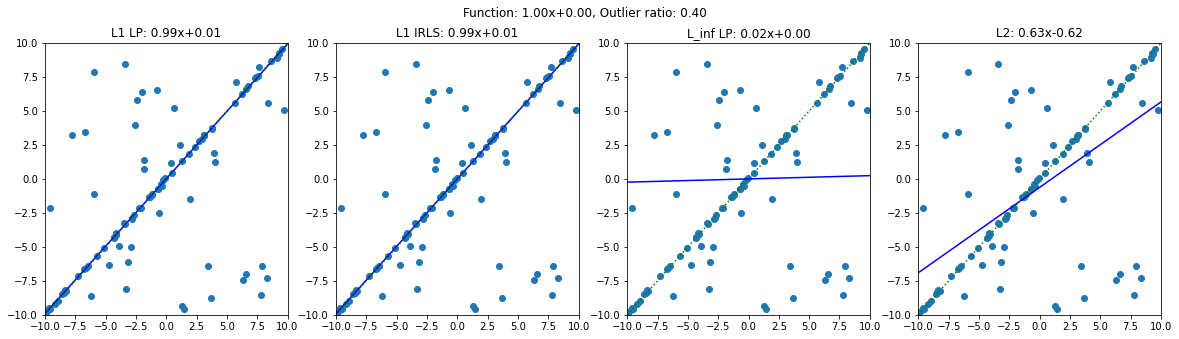

In [23]:
plot_results(0.4)

### 2.4 Discussion
The most important observation is that the $L_1$ loss is much more robust than the $L_\infty$. The first plot shows a noisy line without outliers. All losses ($L_1, L_\infty, L_2$) recover the underlying line correctly. When adding 10% outliers (second plot), we see that the $L_\infty$ is not able to recover the true line because we minimize the maximum error. Already a single outlier has a very large influence on the resulting fit. The $L_1$ loss recovers the line correctly (up to small errors) and the $L_2$ loss also gives an acceptable fit (but less accurate than $L_1$). With 40% outliers, only the $L_1$ loss is able to recover the line. The $L_1$ loss is much less sensitive to outliers because it only penalizes the absolute distance to the line. Therefore, outliers have less influence.

The $L_1$ fit can be computed using linear programming or IRLS. Both variants give the same results. An advantage of IRLS is that it is much more general than LP: one can choose an arbitrary $L_p$ loss and also use non-linear functions (the resulting weightes least-squares can then be solved using e.g. Levenberg-Marquardt). Furthermore, it is easier to implement if no solver for LPs is available.